In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# download and extract the MNIST data set
trainset = datasets.MNIST(root='./data', train=True, download=True,
                          transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all training and test images and labels into PyTorch tensors
train_images, train_labels = extract(trainset)
test_images, test_labels = extract(testset)

# flatten training and test images to vectors with 28 x 28 = 784 entries
# and move to the GPU if available
train_images = train_images.view(-1, 784).to(device)
test_images = test_images.view(-1, 784).to(device)

# Probabilistic PCA

In this notebook we will train and analyze a probabilistic PCA model on the MNIST data set. Our goal is to perform dimensionality reduction: we reduce the high-dimensional images to a two-dimensional representation that still captures some of the important aspects of the images. We will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the MNIST data set.

## Before you start

In exercise 11.1 we performed a (non-probabilistic!) PCA on the MNIST data. It is strongly recommended to solve exercise 11.1 before working through this notebook. You can download the notebook for exercise 11.1 [here](https://uu-sml.github.io/course-apml-public/exercises/Session11.ipynb) and run it on your computer, or you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/exercises/Session11.ipynb).

In this notebook we use [PyTorch](https://pytorch.org/), an open source software library for machine learning. Make sure that you have installed the latest version of PyTorch if you run the notebook on your computer. Alternatively, you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/PPCA.ipynb), which also allows you to use GPUs which might speed up some computations.

A Jupyter notebook with an introduction to PyTorch can be downloaded from [here](https://uu-sml.github.io/course-sml-public/lab/introduction.ipynb). Alternatively, you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-sml-public/blob/master/lab/introduction.ipynb). Reading and running the notebook is highly recommended, since it introduces important concepts and commands that are required in this notebook.

## Theoretical background

Let $\mathbf{x} \in \mathbb{R}^{784}$ represent a $28 \times 28$-pixel grayscale image and $\mathbf{z} \in \mathbb{R}^M$ be an $M$-dimensional latent variable with $M < 784$.

Instead of regular PCA we now use [probabilistic PCA](https://rss.onlinelibrary.wiley.com/doi/10.1111/1467-9868.00196) as a model for dimensionality reduction and feature extraction, since probabilistic PCA can be altered and extended quite easily and allows a probabilistic interpretation of the encodings, which helps us with generating new MNIST-like images. In our setting, the probabilistic PCA model is given by 
\begin{align*}
  p(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mathbf{W}\mathbf{z} + \boldsymbol{\mu}, \sigma^2 \mathbf{I}_{784}\right), \\
  p(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_M),
\end{align*}
with parameters $\mathbf{W} \in \mathbb{R}^{784 \times M}$, $\boldsymbol{\mu} \in \mathbb{R}^{784}$, and $\sigma^2 > 0$.

In the preparatory exercises, you showed that for the probabilistic PCA model
\begin{equation*}
    p(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \mathbf{C}),
\end{equation*}
where
\begin{equation*}
    \mathbf{C} = \mathbf{W} \mathbf{W}^\intercal + \sigma^2 \mathbf{I}_{784}.
\end{equation*}
Thus the log-likelihood of i.i.d. data samples $\{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ is given by
\begin{equation*}
    \log p(\mathbf{x}_1, \ldots, \mathbf{x}_N; \mathbf{W}, \boldsymbol{\mu}, \sigma^2) = - \frac{N}{2}(784 \log{(2\pi)} + \log{|\mathbf{C}|}) - \frac{1}{2} \sum_{n=1}^N {(\mathbf{x}_n - \boldsymbol{\mu})}^\intercal {\mathbf{C}}^{-1} {(\mathbf{x}_n - \boldsymbol{\mu})}.
\end{equation*}

## Cost function

[Tipping and Bishop](https://rss.onlinelibrary.wiley.com/doi/10.1111/1467-9868.00196) actually derived an expression for the maximum likelihood solution of $\mathbf{W}$, $\boldsymbol{\mu}$, and $\sigma^2$. However, in this lab we do not try to obtain the maximum likelihood solution with the algorithms suggested in their original work. Instead, since the log-likelihood is differentiable with respect to the parameters, we will optimize the parameters with gradient descent, similar to the linear regression example in the Jupyter notebook [Introduction to PyTorch](https://uu-sml.github.io/course-sml-public/lab/introduction.ipynb) (you can also [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-sml-public/blob/master/lab/introduction.ipynb)).

We try to minimize the cost function
\begin{equation*}
  J(\mathbf{W}, \boldsymbol{\mu}, \sigma^2) = \log{|\mathbf{C}|} + \frac{1}{N} \sum_{n=1}^N {(\mathbf{x}_n - \boldsymbol{\mu})}^\mathsf{T} {\mathbf{C}}^{-1} {(\mathbf{x}_n - \boldsymbol{\mu})},
\end{equation*}
where we neglected all additive constant terms of the log-likelihood and scaled it by $N / 2$.

It is computationally much cheaper to work with the
matrix
\begin{equation*}
\mathbf{M} = \mathbf{W}^\mathsf{T} \mathbf{W} + \sigma^2 \mathbf{I}_M \in \mathbb{R}^{M \times M}
\end{equation*}
than with the matrix $\mathbf{C} \in \mathbb{R}^{784 \times 784}$.
Actually one can exploit the special structure of the matrix
$\mathbf{C}$ and use the [matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma#Generalization) and the [Woodbury matrix identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to show that
\begin{equation*}
      J(\mathbf{W}, \boldsymbol{\mu}, \sigma^2) = (784 - M) \log \sigma^2 +
      \log{|\mathbf{M}|} +
      \frac{1}{N\sigma^2} \sum_{n=1}^N \left(\|\mathbf{x}_n - \boldsymbol{\mu}\|_2^2 -
        {(\mathbf{x}_n - \boldsymbol{\mu})}^\mathsf{T} \mathbf{W}
        {\mathbf{M}}^{-1} \mathbf{W}^\mathsf{T}
        (\mathbf{x}_n - \boldsymbol{\mu}) \right).
\end{equation*}

Here we consider $M = 2$, i.e., $\mathbf{z}$ is two-dimensional. We start by implementing the cost function.

### Task

The following Python function `cost_function` will be used to evaluate the cost function $J$ for a given data set
\begin{equation*}
\mathbf{X} = \begin{bmatrix} \mathbf{x}_1^\intercal \\ \vdots \\ \mathbf{x}_N^\intercal \end{bmatrix}
\end{equation*}
and parameters $\mathbf{W}$, $\boldsymbol{\mu}$, and $\log \sigma^2$. To enforce $\sigma^2 > 0$, we optimize the real-valued parameter $\log \sigma^2$ instead of $\sigma^2$. Read through and try to understand the existing implementation. Add a final line to the function that computes and returns the value of the cost function by making use of the already computed values and matrices.

*Hint*: Use the PyTorch functions [`torch.pow`](https://pytorch.org/docs/stable/torch.html#torch.pow) for taking the power of each element in a PyTorch tensor, and [`torch.sum`](https://pytorch.org/docs/stable/torch.html#torch.sum) and [`torch.mean`](https://pytorch.org/docs/stable/torch.html#torch.mean) for computing the sum and the mean of a PyTorch tensor (it is possible to specify the dimension along which the operation should be performed).

In [3]:
def cost_function(X, W, mu, logsigma2):
    # flatten the data into a matrix with 28 x 28 = 784 columns
    X = X.view(-1, 784)

    # compute matrix Xshifted with rows (x_n - mu)^T
    # note: mu is defined as a row vector
    Xshifted = X - mu
    
    # compute matrix Y with rows (x_n - mu)^T * W
    Y = Xshifted.mm(W)

    # compute matrix M = W^T * W + sigma^2 I
    sigma2 = logsigma2.exp()
    M = W.t().mm(W) + torch.diagflat(sigma2.expand(2))

    # compute the log-determinant of M
    Mlogdet = M.logdet()

    # compute the inverse of M
    Minverse = M.inverse()

    # compute vector v with v[n] = (x_n - mu)^T * W * M^(-1) * W^T * (x_n - mu)
    v = Y.mm(Minverse).mm(Y.t()).diagonal()
    
    # put everything together and compute loss
    return 782*logsigma2 + Mlogdet + (1/sigma2)*torch.mean(torch.sum(torch.pow(Xshifted, 2), dim=1) - v)

#### Note

In particular for higher-dimensional latent spaces one would want to use the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf{M}$ to speed up the computation of $\log{|\mathbf{M}|}$ and ${(\mathbf{x}_n - \boldsymbol{\mu})}^\mathsf{T} \mathbf{W} {\mathbf{M}}^{-1} \mathbf{W}^\mathsf{T} (\mathbf{x}_n - \boldsymbol{\mu})$ (actually, that is exactly how it is implemented in [PyTorch](https://pytorch.org/docs/stable/_modules/torch/distributions/lowrank_multivariate_normal.html)).

## Training

We train the model with [Adam](https://arxiv.org/abs/1412.6980), a gradient-based optimization algorithm with adaptive learning rates for different parameters. Instead of evaluating the gradient based on all images in the training data set
in every step, we compute it from a randomly chosen subset of the training data, a so-called minibatch. The main idea is that the gradients computed from a large enough random subset of the data should be roughly similar to the gradient evaluated on the whole data set, but by using a subset of the data set the computation time can be improved.

In PyTorch data loaders are used for iterating through minibatches. The following code snippet creates data loaders of the MNIST training and test data sets that return minibatches of 500 images and their corresponding labels upon iteration. The samples in the training data set are shuffled whereas the samples in the test data set are always returned in the same order.

In [4]:
# define data loaders
# `pin_memory=True` is helpful when working with GPUs: https://pytorch.org/docs/stable/data.html#memory-pinning
train_data = torch.utils.data.DataLoader(
    trainset, batch_size=500, shuffle=True, pin_memory=device.type=='cuda'
)
test_data = torch.utils.data.DataLoader(
    testset, batch_size=500, pin_memory=device.type=='cuda'
)

The next code snippet shows a complete implementation of the training procedure.

Epoch  1: training loss  -749.477, test loss  -754.943
Epoch  2: training loss -1301.221, test loss -1305.648
Epoch  3: training loss -1458.010, test loss -1456.241
Epoch  4: training loss -1457.415, test loss -1465.562
Epoch  5: training loss -1447.528, test loss -1466.279
Epoch  6: training loss -1479.156, test loss -1466.518
Epoch  7: training loss -1485.057, test loss -1467.521
Epoch  8: training loss -1462.197, test loss -1467.756
Epoch  9: training loss -1464.429, test loss -1467.324
Epoch 10: training loss -1461.062, test loss -1467.596
Epoch 11: training loss -1463.289, test loss -1467.978
Epoch 12: training loss -1475.271, test loss -1468.360
Epoch 13: training loss -1467.807, test loss -1467.846
Epoch 14: training loss -1464.680, test loss -1467.849
Epoch 15: training loss -1463.898, test loss -1467.716
Epoch 16: training loss -1457.104, test loss -1467.847
Epoch 17: training loss -1453.736, test loss -1468.142
Epoch 18: training loss -1436.919, test loss -1467.884
Epoch 19: 

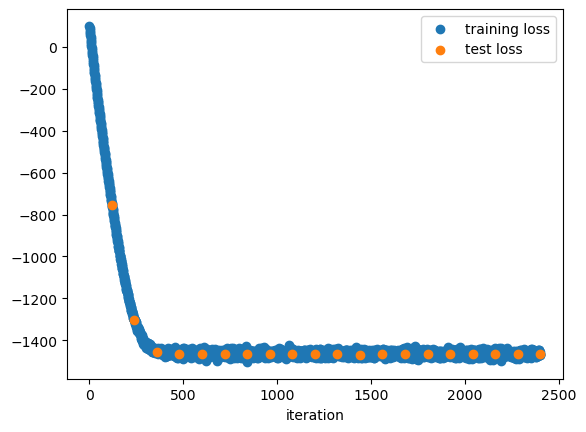

In [5]:
# define the initial model parameters
# we use the GPU if available (`device=device`)
# and track gradient information (`requires_grad=True`)
W = torch.randn((784, 2), device=device, requires_grad=True)
mu = torch.zeros(1, 784, device=device, requires_grad=True)
logsigma2 = torch.zeros(1, device=device, requires_grad=True)

# define the optimizer
optimizer = optim.Adam([W, mu, logsigma2], lr=0.01)

# track the training and test loss
training_loss = []
test_loss = []

# optimize parameters for 20 epochs
for i in range(20):
    # for each minibatch
    for batch_X, _ in train_data:
        # move batch to the GPU if available
        batch_X = batch_X.to(device)

        # reset the gradient information
        optimizer.zero_grad()

        # evaluate the cost function on the training data set
        loss = cost_function(batch_X, W, mu, logsigma2)

        # update the statistics
        training_loss.append(loss.item())
        test_loss.append(float('nan'))

        # perform backpropagation
        loss.backward()

        # perform a gradient descent step
        optimizer.step()

    # evaluate the model after every epoch
    with torch.no_grad():
        # evaluate the cost function on the test data set
        accumulated_loss = 0
        for batch_X, _ in test_data:
            # move batch to the GPU if available
            batch_X = batch_X.to(device)

            # compute loss
            loss = cost_function(batch_X, W, mu, logsigma2)
            accumulated_loss += loss.item()

        # update the statistics
        test_loss[-1] = accumulated_loss / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
        
# plot the tracked statistics
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

### Task

Read through and try to understand the implementation of the training procedure above. Answer the following questions:

- How does it differ from the implementation of the training procedure in the linear regression example?

We use mini-batches and train in epochs. We use our cost function instead of MSE. We use ADAM as optimizer.

- How were the parameters initialized?

The weights $\mathbf{W}$ were initialized with random numbers, $\boldsymbol{\mu}$ and $\log \sigma^2$ were initialized with zeros.
- What learning rate did we use in the gradient descent algorithm?

$lr = 0.01$.

- For how many iterations was the model trained?

Epochs * minibatches = Epochs * N/batch size = 20 * 60 000 / 500 = 20 * 120 = 2400

Since we do not update the parameters anymore, no gradients have to be computed in the following sections. We can prevent PyTorch from tracking all our computations and building computational graphs by changing the attribute `requires_grad`.

In [6]:
W.requires_grad = False
mu.requires_grad = False
logsigma2.requires_grad = False

## Encodings 

In the preparatory exercises we showed that the distribution of the latent representation $\mathbf{z}$ conditioned on an image $\mathbf{x}$ is also Gaussian and given by
\begin{equation*}
    p(\mathbf{z} \,|\, \mathbf{x}) = \mathcal{N}\left(\mathbf{z}; \mathbf{M}^{-1} \mathbf{W}^\mathsf{T} (\mathbf{x} - \boldsymbol{\mu}), \sigma^2 \mathbf{M}^{-1}\right),
\end{equation*}
where
\begin{equation*}
\mathbf{M} = \mathbf{W}^\mathsf{T} \mathbf{W} + \sigma^2 \mathbf{I}_2.
\end{equation*}
We can use this result to encode the MNIST images in the lower-dimensional latent space. In contrast to regular PCA there exists not one unique representation of an image in the latent space, but instead each image gives rise to a whole distribution of representations in the latent space. Here we use the mean
\begin{equation*}
\mathbf{M}^{-1} \mathbf{W}^\mathsf{T} (\mathbf{x} - \boldsymbol{\mu})
\end{equation*}
of the normal distribution as encoding. Alternatively, one could sample from the normal distribution.

In [7]:
# compute M = W^T * W + sigma^2 * I
M = W.t().mm(W) + torch.diagflat(logsigma2.exp().expand(2))

# compute the inverse of M
Minv = torch.inverse(M)

# compute encodings of the training images
# use the GPU if available
train_encodings = (train_images - mu).mm(W).mm(Minv)

# compute encodings of the test images
# use the GPU if available
test_encodings = (test_images - mu).mm(W).mm(Minv)

We generate 2D scatter plots of the encodings that show the clusters for different labels in the label space. We make use of the function `plot_encodings` below.

In [8]:
# plot `train_encodings` and `test_encodings` with colorcoding of the corresponding labels
def plot_encodings(train_encodings, train_labels, test_encodings, test_labels):
    # create two plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # plot encodings of training data
    ax = axes[0]
    ax.scatter(
        train_encodings[:, 0].cpu().numpy(), train_encodings[:, 1].cpu().numpy(),
        c=train_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("training data")
    
    # plot encodings of test data
    ax = axes[1]
    scatter = ax.scatter(
        test_encodings[:, 0].cpu().numpy(), test_encodings[:, 1].cpu().numpy(),
        c=test_labels, cmap=plt.cm.tab10, vmin=-0.5, vmax=9.5, alpha=0.7
    )
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title("test data")

    # add colorbar
    cb = fig.colorbar(scatter, ticks=range(10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")
    
    return fig

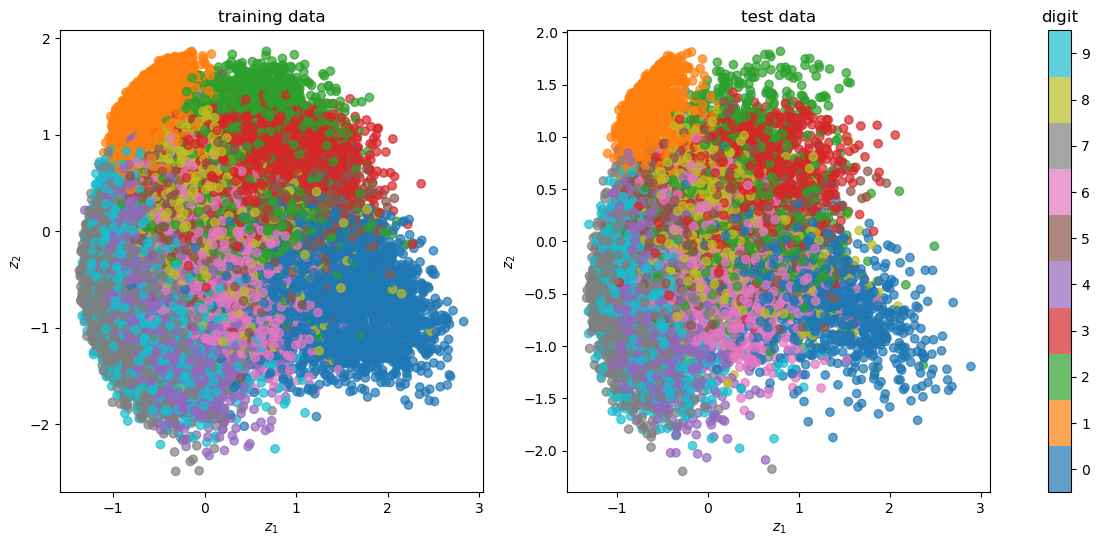

In [9]:
plot_encodings(train_encodings, train_labels, test_encodings, test_labels)
plt.show()

### Task

Compare the encodings of the test images with the encodings for regular PCA in exercise 11.1. Are they different and, if yes, in what ways?

*Hint:* Inspect also the range of the axes for $z_1$ and $z_2$ in both plots.

They differ in that the axis scales are smaller for PPCA. The probabilistic encodings for PPCA are closer to each other than the deterministic encodings for PCA. 

## Decodings

We can decode the representations in the latent space, according to the definition of the decoding distribution
\begin{equation*}
  p(\mathbf{x} \,|\, \mathbf{z}) = \mathcal{N}\left(\mathbf{x}; \mathbf{W}\mathbf{z} + \boldsymbol{\mu}, \sigma^2 \mathbf{I}_{784}\right)
\end{equation*}
in the probabilistic PCA model.
Again in contrast to regular PCA, the model provides us with a whole distribution of possible decodings. Analogously to the encodings discussed above, here we take the mean
\begin{equation*}
\overline{\mathbf{x}} = \mathbf{W}\mathbf{z} + \boldsymbol{\mu}
\end{equation*}
of the normal distribution as representative decoding. Of course, alternatively we could sample from the normal distribution defined by the probabilistic PCA model.

### Task

Compute the reconstructions of the test images by mapping the encodings of the test data from the latent space back to the space of images.

*Hint*: It might be easier to work with the equivalent formulation $\overline{\mathbf{x}}^\mathsf{T} = \mathbf{z}^\intercal \mathbf{W}^\mathsf{T} + \boldsymbol{\mu}^\mathsf{T}$. Note that `mu` is defined as the row vector $\boldsymbol{\mu}^\mathsf{T}$!

In [10]:
test_reconstructions = torch.mm(test_encodings, W.t()) + mu

### Task

As in regular PCA, it is interesting to compare an image $\mathbf{x}$ with its reconstruction $\mathbf{\tilde{x}}$, to see how much information about $\mathbf{x}$ is kept/lost by the reduction of $\mathbf{x}$ to its representation in the latent space. Plot the reconstructions alongside the original images with the function `plot_reconstructions` below. 

In [11]:
# plot a grid of random pairs of `originals` and `reconstructions`
def plot_reconstructions(originals, reconstructions, labels, num_rows=4, num_cols=2):
    # indices of displayed samples
    n = originals.shape[0]
    indices = np.random.choice(n, size=num_rows*num_cols, replace=False)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))
    for (idx, ax) in zip(indices, axes.flat):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.set_title(f"Label: {label.item()}", fontweight='bold')

        # plot original and reconstructed image in a grid
        grid = np.ones((32, 62))
        grid[2:30, 2:30] = original.view(28, 28).cpu().numpy()
        grid[2:30, 32:60] = reconstruction.view(28, 28).cpu().numpy()
        ax.imshow(grid, vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

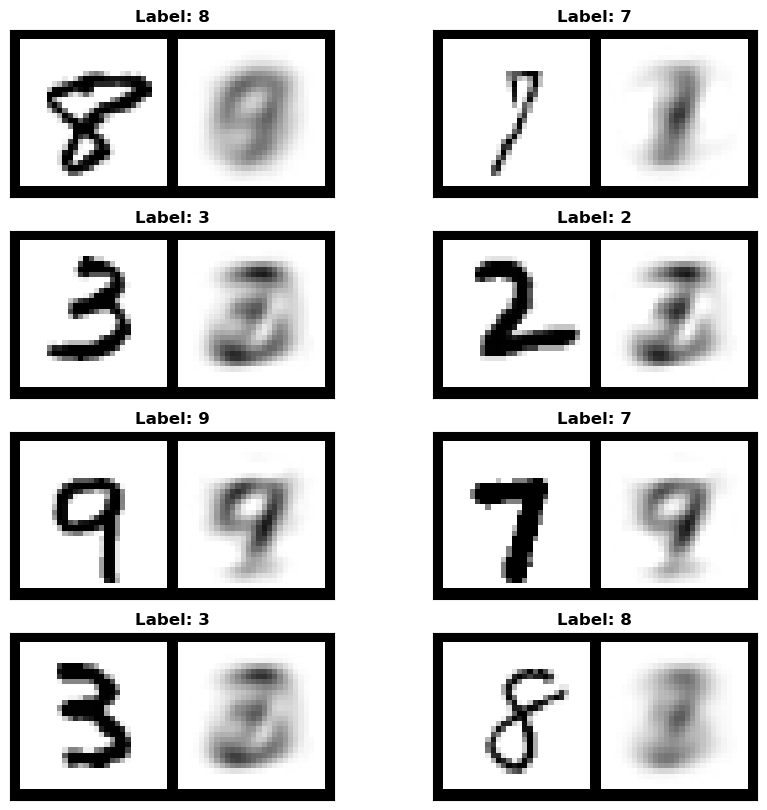

In [12]:
plot_reconstructions(test_images, test_reconstructions, test_labels)
plt.show()

Moreover, as in exercise 11.1 for regular PCA, we evaluate the average squared reconstruction error
\begin{equation*}
\mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstructions $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set. It serves as an objective measure for the quality of the reconstructions.

### Task

Compute the average squared reconstruction error.

In [13]:
sqerr = torch.sum(torch.pow(test_images - test_reconstructions,2))/len(test_images)
print(f'Average squared reconstruction error: {sqerr}')

Average squared reconstruction error: 43.71369552612305


#### Note

As discussed above, different encodings and decodings could be considered in the probabilistic settings, leading to different reconstructions. The reconstruction that we use is [not optimal in the squared reconstruction error sense](https://rss.onlinelibrary.wiley.com/doi/10.1111/1467-9868.00196), and hence the average squared reconstruction error could be improved by defining it in a different way.

### Task

Now we have performed exactly the same analysis as for the regular PCA in exercise 11.1. Compare the results you obtained with regular PCA and the probabilistic PCA model, and answer the following questions:
- Which digits can be reconstructed and decoded quite well, and which ones seem to be more challenging? Are there differences between both approaches?

0 and 3 seems to be the only ones close to being replicable, the rest are more challenging. The differences between both approaches do not seem very significant.

- Is the average squared reconstruction error the same as with regular PCA?

Very close to being equal.

## Generating new images


In regular PCA, a priori no distribution of the latent representations is specified by the model. Hence it is difficult to know which encodings might produce reasonably looking images, which makes sampling new encodings and hence new images challenging. In contrast, probabilistic PCA defines the marginal distribution $p(\mathbf{z})= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$. Thus we can generate new MNIST-like images by sampling encodings from this distribution and decoding them.

### Task

#### (a)

Generate 25 images by sampling encodings from $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$ and decoding them. Plot them with the function `plot_images` below.

#### (b)

Sometimes the quality of samples can be improved by tuning the so-called temperature of the prior (see, e.g., [this paper](https://arxiv.org/pdf/1807.03039.pdf) and the references therein). Here, sampling with temperature $T > 0$ corresponds to sampling the encodings from $\mathcal{N}(\boldsymbol{0}, T^2\mathbf{I}_2)$ instead of $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$. Hence sampling with temperature $T = 1$ corresponds to sampling from the prior $p_{\boldsymbol{\theta}}(\mathbf{z})$ performed in a). Try different values of $T$ and study how it affects the quality of the samples.

In [14]:
# plot a grid of `images` with `nrows` rows and `ncols` columns
def plot_images(images, nrows=5, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2 * nrows))
    for image, ax in zip(images, axes.flat):
        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        
        # plot image
        ax.imshow(image.view(28, 28).cpu().numpy(),
                  vmin=0.0, vmax=1.0, cmap='gray_r')
        
    return fig

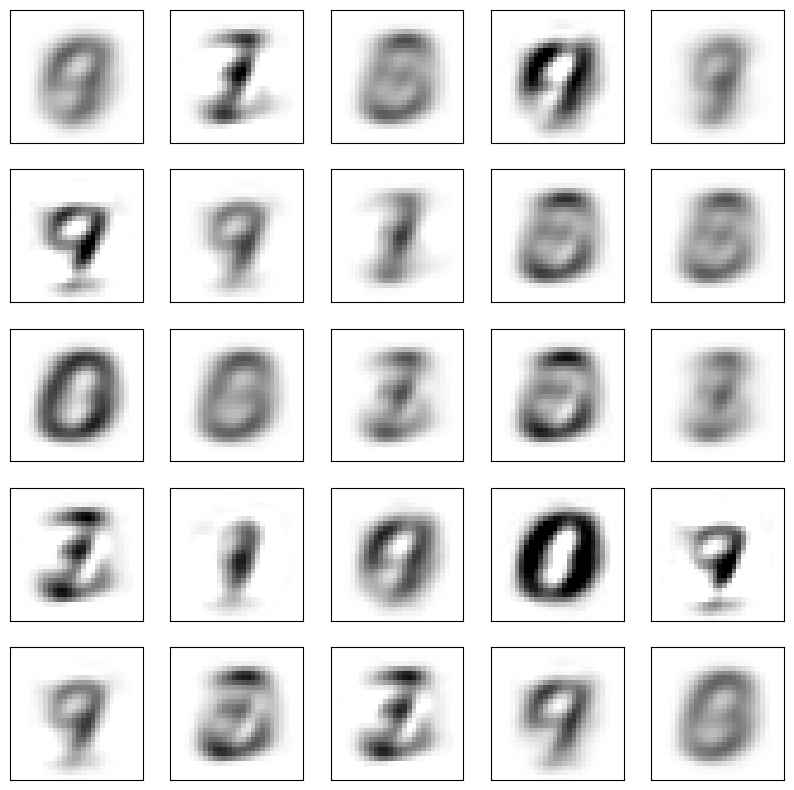

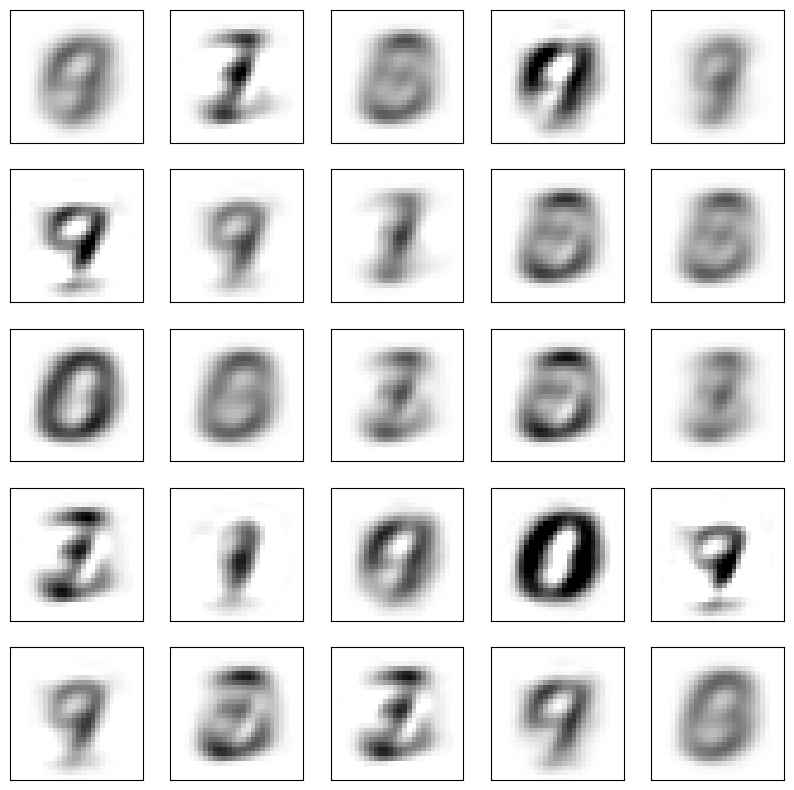

In [17]:
T = 1
encodings = torch.normal(0, T**2, size=(25,2)).to(device)
images = torch.mm(encodings, W.t()) + mu
plot_images(images)

In [16]:
W.t().shape

torch.Size([2, 784])

- Very small numbers (e.g. 0.001) -> every image looks identical
- Bigger numbers -> High variance, a lot of noise, but better separation between images

## Summary

In this notebook we trained and analyzed a probabilistic PCA model on MNIST data. Although the PPCA model is more difficult to train than regular PCA, we can generate new MNIST-like images in a general way now! Unfortunately, to be honest, the generated images do not look great. As in regular PCA, we could improve the quality of the reconstructions and samples by increasing the dimension of the latent space. You can try to modify the code accordingly if you want to but it is not a mandatory task.